# Phase plane plot

# Purpose
Exploring the possibilities with *phase plane plots*

# Methodology
Quickly describe assumptions and processing steps.

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [9]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [333]:
from scipy.integrate import solve_ivp
from sympy.physics.vector import dynamicsymbols
from sympy.matrices import Matrix

## Matplotlib example

Text(0.5, 1.0, 'Varying Density')

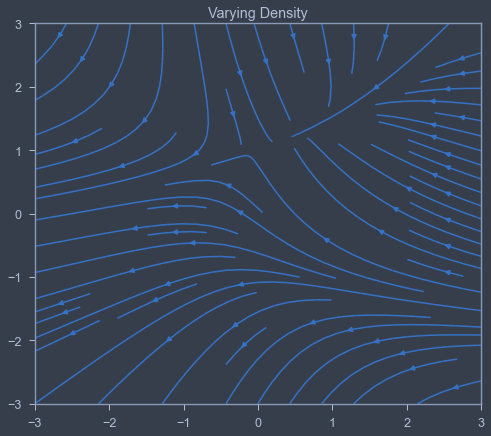

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

w = 3
Y, X = np.mgrid[-w:w:100j, -w:w:100j]
U = -1 - X**2 + Y
V = 1 + X - Y**2
speed = np.sqrt(U**2 + V**2)

fig,ax=plt.subplots()
ax.streamplot(X, Y, U, V, density=[0.5, 1])
ax.set_title('Varying Density')

## Example from book (CH2: Flows on the line)
Logistic equation ($r=1$, $K=1$):
$$\dot{x} = x\cdot(1-x)$$

In [109]:
def logistic_equation(t,x):
    xd1 = x*(1-x)
    return xd1
        

In [110]:
dt = 0.5
t = np.arange(0,10,dt)
n_x = 15
x = np.linspace(0,2,n_x)

In [111]:
T = np.tile(t,(n_x,1))
T.shape

(15, 20)

In [112]:
X = np.tile(x,(len(t),1)).T
X.shape

(15, 20)

In [113]:
dT = dt*np.ones((n_x,len(t)))
dT.shape

(15, 20)

In [114]:
dXdT = logistic_equation(t=T,x=X)

In [142]:
x0s = [2,1,0.5,0.03,0.03]
t0s = [0,0,5,0,3]
xs = []
sims = OrderedDict()

for t0,x0 in zip(t0s,x0s):
    t_ = np.linspace(t0,t[-1],100)
    t_span = (t_[0],t_[-1])
    result = solve_ivp(fun = logistic_equation, t_span=t_span,  y0=[x0], t_eval=t_)
    
    sim = {
        't':t_,
        'x':result.y[0],
    }
    key = (t0,x0)
    sims[key]=sim
    

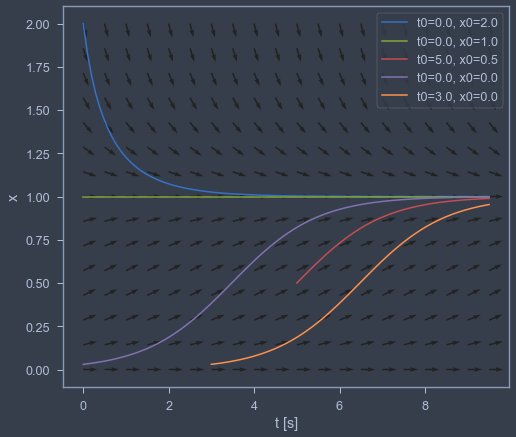

In [207]:
fig,ax=plt.subplots()

# Normalize the arrows:
lengths = np.sqrt(dT**2 + dXdT**2)
U = dT / lengths
V = dXdT / lengths

ax.quiver(T, X, U, V)

for key,sim in sims.items():
    label = 't0=%0.1f, x0=%0.1f' % key
    ax.plot(sim['t'],sim['x'], label=label)

ax.set_ylabel('x')
ax.set_xlabel('t [s]')
ax.legend();

## Example from book (CH5: Linear systems)
Spring-mass system:

In [307]:
m,k,omega = sp.symbols('m k omega')
x,v = dynamicsymbols('x v')
eq = sp.Eq(m*x.diff().diff() + k*x,0)
Math(vlatex(eq))

<IPython.core.display.Math object>

In [340]:
eq_xdiff = sp.Eq(v,x.diff())
Math(vlatex(eq_xdiff))

<IPython.core.display.Math object>

In [327]:
eq_v = eq.subs(x.diff().diff(),v.diff())
eq_v_diff = sp.Eq(v.diff(),sp.solve(eq_v,v.diff())[0])
Math(vlatex(eq_v_diff))

<IPython.core.display.Math object>

In [328]:
eq_omega = sp.Eq(omega**2,k/m)
eq_omega

Eq(omega**2, k/m)

In [329]:
eq_v_diff_omega = eq_v_diff.subs(eq_omega.rhs,eq_omega.lhs)
Math(vlatex(eq_v_diff_omega))

<IPython.core.display.Math object>

In [336]:
state = Matrix([x,v])
Math(vlatex(state))

<IPython.core.display.Math object>

In [344]:
eq_state_diff = sp.Eq(state.diff(), Matrix([sp.solve(eq_xdiff,x.diff()),
                            sp.solve(eq_v_diff_omega,v.diff())]))

Math(vlatex(eq_state_diff))

<IPython.core.display.Math object>

In [373]:
A = Matrix([[0, 1],[-omega**2,0]])
A

Matrix([
[        0, 1],
[-omega**2, 0]])

In [374]:
A*state

Matrix([
[          v(t)],
[-omega**2*x(t)]])

In [382]:
np.array([[0,1],[-omega_**2,0]]).dot(state).shape

(2, 100)

In [405]:
def update(t,state, omega=1):
        
    state_diff = np.array([[0,1],[-omega**2,0]]).dot(state)
    
    return state_diff

Text(0, 0.5, 'v [m/s]')

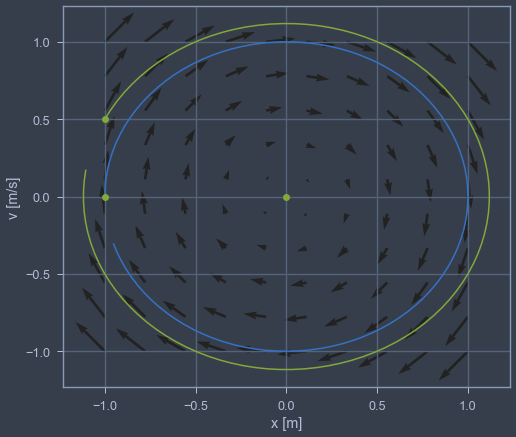

In [421]:
N = 10
v_ = np.linspace(-1.0,1.0,N)
x_ = np.linspace(-1.0,1.0,N) 
omega_ = 1.0
X,V=np.meshgrid(x_,v_)
state = np.array([X.flatten(),V.flatten()])

state_diff = update(0, state, omega=omega_)
fig,ax=plt.subplots()
ax.quiver(X, V, state_diff[0,:], state_diff[1,:])

x0s = [-1.0,-1,0]
v0s = [0.0,0.5,0]
xs = []
sims = OrderedDict()

t_ = np.linspace(0,1.9*np.pi/omega_,100)

for x0,v0 in zip(x0s,v0s):
    
    t_span = (t_[0],t_[-1])
    result = solve_ivp(fun = update, t_span=t_span,  y0=[x0,v0], t_eval=t_, args=(omega_,))
    ax.plot(result.y[0,:],result.y[1,:])
    ax.plot(x0,v0,'go')
    
ax.grid(True)
ax.set_xlabel('x [m]')
ax.set_ylabel('v [m/s]')

I was puzzled that you could plot time derivatives in the vector field. Plotting $\frac{dx}{dt}$ on the x-axis, which has physical unit meters must be wrong. But I think instead that each arrow is a small time step, so that each derivative has been integrated to obtain the correct physical unit. And in this linear case the integration has been $\frac{dx}{dt} \cdot \Delta t$, so that each arrow has the slope:
\begin{bmatrix}
\frac{dx}{dt} \\ 
\frac{dv}{dt}
\end{bmatrix}

## Roll decay

In [330]:
Math(vlatex(equations.roll_decay_equation_cubic))

<IPython.core.display.Math object>

In [331]:
x1, x2 = dynamicsymbols('x1 x2')


In [332]:
Math(vlatex(x1.diff()))

<IPython.core.display.Math object>

In [249]:
roll_decay_equation_cubic_canonical = equations.roll_decay_equation_cubic.subs([
    (symbols.phi_dot,x2),
    (symbols.phi,x1),
])

In [250]:
Math(vlatex(roll_decay_equation_cubic_canonical))

<IPython.core.display.Math object>

In [253]:
eq_acceleration_quadratic = sp.Eq(x2.diff(),
                        sp.solve(roll_decay_equation_cubic_canonical,x2.diff())[0])



In [255]:
Math(vlatex(eq_acceleration_quadratic))

<IPython.core.display.Math object>

In [256]:
accelaration_quadratic_lambda = lambdify(sp.solve(eq_acceleration_quadratic,x2.diff())[0])

In [257]:
accelaration_quadratic_lambda

<function _lambdifygenerated(A_44, B_1, B_2, B_3, C_1, C_3, C_5, x1, x2)>

In [266]:
class RollDecayCubic():
    
    def __init__(self,A_44, B_1, B_2, B_3, C_1, C_3, C_5,**kwargs):
        self.parameters = {
            'A_44':A_44,
            'B_1':B_1,
            'B_2':B_2,
            'B_3':B_3,
            'C_1':C_1,
            'C_3':C_3,
            'C_5':C_5,
        }
            
    def time_step(self,t,states):
        
        x1 = states[0]
        x2 = states[1]
        x21d = accelaration_quadratic_lambda(**self.parameters, x1=x1, x2=x2)
        d_states_dt = np.array([x2, x21d])
        
        return d_states_dt
    
    def simulate(self,t,phi0=np.deg2rad(10),phi1d0=0):
        
        initial_state = [phi0,phi1d0]
        
        t_span = [t[0], t[-1]]
        
        result = solve_ivp(fun=simulation.time_step, t_span=t_span,  y0=initial_state, t_eval=t)
        assert result.success
        df_result = pd.DataFrame(index=result.t, data=result.y.T, columns = ['phi','phi1d'])
        return df_result

In [267]:
parameters = {
 'B_2A': 0.052059778389283974,
 'C_3A': -3.1821206941051803,
 'C_1A': 6.088581805080991,
 'B_3A': 0.0028870139489360486,
 'C_5A': 396.2046786411697,
 'B_1A': 0.05572815192117509,
 'score': 0.9992140495309503,
 'phi_start': 0.16293739741722763,
 'phi_stop': 0.036667136224551956,
 'omega0_fft': 2.4755750032144674,
 'A_44': 135.00020663291045,
 'B_2': 7.02808083981686,
 'C_3': -429.586951235060,
 'C_1': 821.959801787313,
 'B_3': 0.389747479658461,
 'C_5': 53487.7134854838,
 'B_1': 7.52331202462886,
 'omega0': 2.4675051783291138}

simulation = RollDecayCubic(**parameters)

In [424]:
phi0 = np.deg2rad(9.335625196852943)
phi01d = 0
t = np.arange(24.39,72.73,0.01)
df_result = simulation.simulate(t=t,phi0=phi0, phi1d0=phi01d)

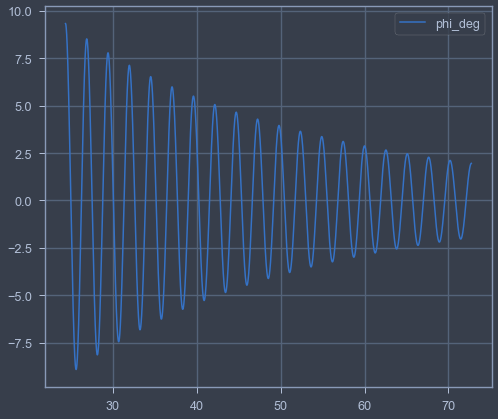

In [425]:
fig,ax=plt.subplots()
df_result['phi_deg'] = np.rad2deg(df_result['phi'])
df_result.plot(y='phi_deg', ax=ax)
ax.grid(True)

<AxesSubplot:xlabel='phi'>

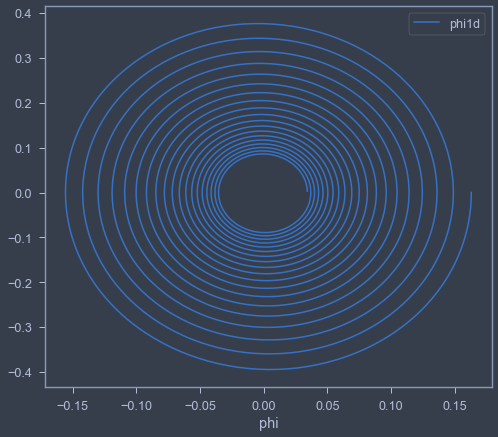

In [426]:
fig,ax=plt.subplots()
df_result.plot(x='phi', y='phi1d', ax=ax)
#ax.set_aspect('equal', 'box')